# Image Analyzer for grain shape identification

In [1]:
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.utils import np_utils
import os
import glob
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten, Dropout
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from skimage import io
import numpy as np
import ipdb
import cv2
from joblib import Parallel, delayed
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator


# https://qiita.com/uni-3/items/a62daa5a03a02f5fa46d




    
class ImageDataset():
    
    def __init__(self, image_shape_x, image_shape_y, num_classes):
#        self.image_shape = (512, 512, 3) # image is 512 x 512 x 3 (RGB)
#        self.num_pixels = 512 * 512
        self.image_shape = (image_shape_x, image_shape_y, 3)
        self.num_pixels = self.image_shape[0] * self.image_shape[1]
        self.num_classes = num_classes
        self.original_image_shape = []
        
    def get_batch(self, original_images_folder, original_prefix, trace_images_folder, trace_prefix, num_images, num_test_set):
        # x = io.imread_collection(original_images_name)
        # y = io.imread_collection(traced_images_name)
        
        original_list = []
        for i in range(num_images):
            original_list.append(original_prefix + '{}.tif'.format(i))

        trace_list = []
        for i in range(num_images):
            trace_list.append(trace_prefix + '{}.tif'.format(i))

        x = []
        for filename in original_list:
            img = cv2.imread(os.path.join(original_images_folder,filename))
            if img is not None:
                x.append(img)
        
        img = Parallel(n_jobs=-1, backend='threading')(delayed(cv2.imread)(os.path.join(original_image_folder,filename) for filename in original_list))
        if img is not None:
                x.append(img)
        
        y = []
        for filename in trace_list:
            img = cv2.imread(os.path.join(trace_images_folder,filename))
            if img is not None:
                y.append(img)
                
        img = Parallel(n_jobs=-1, backend='threading')(delayed(cv2.imread)(os.path.join(trace_images_folder,filename) for filename in trace_list))
        if img is not None:
                y.append(img)
        
        self.original_image_shape = y[0].shape
        

        
        # split images
        x_division = int(x[0].shape[0] / self.image_shape[0])
        y_division = int(x[0].shape[1] / self.image_shape[1])
        
        x_set_list = []
        y_set_list = []
        
#         for i in range(len(y)):
        for i in range(len(x)):
            x_norm = self.normalize(x[i])
            y_gray = (np.sum(y[i][:, :, :], axis=2) / (255 * 3)).astype('int64')
            y_label = self.one_hot_it(y_gray)
            for j in range(x_division):
                for k in range(y_division):
                    x_set_list.append(x_norm[
                      j * self.image_shape[0]:(j + 1) * self.image_shape[0],
                      k * self.image_shape[1]:(k + 1) * self.image_shape[1], :])
                    y_label_sub = y_label[j * self.image_shape[0]:(j + 1) * self.image_shape[0],
                      k * self.image_shape[1]:(k + 1) * self.image_shape[1], :]
                    y_set_list.append(y_label_sub)
                    
        x_set = np.array(x_set_list)
        y_set = np.array(y_set_list)
        test = num_test_set
        number_of_imageset = len(x_set)

        x_train = imagenet_utils.preprocess_input(x_set[0:number_of_imageset - test,:,:,:])
        x_test = imagenet_utils.preprocess_input(x_set[number_of_imageset - test:,:,:,:])
        y_train = self.preprocess_y(y_set[0:number_of_imageset - test, :, :, :])
        y_test = self.preprocess_y(y_set[number_of_imageset - test:,:,:,:])
        
        return x_train, y_train, x_test, y_test
    
    def preprocess_y(self, y):
        
        data_shape = self.image_shape[0] * self.image_shape[1]
        
        return np.reshape(y, (y.shape[0], data_shape, self.num_classes))
    
    def one_hot_it(self, labels):
        y = np.zeros([self.original_image_shape[0],self.original_image_shape[1], self.num_classes])
        one = np.where(labels == 1)
        zero = np.where(labels != 1)
        y[one[0], one[1], 1] = 1
        y[zero[0], zero[1], 0] = 1
        return y
    
    def normalize(self, rgb):
        
        norm = np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

        b=rgb[:,:,0]
        g=rgb[:,:,1]
        r=rgb[:,:,2]

        norm[:,:,0] = cv2.equalizeHist(b)
        norm[:,:,1] = cv2.equalizeHist(g)
        norm[:,:,2] = cv2.equalizeHist(r)

        return norm

        
class Trainer():
    
    def __init__(self, model, loss="categorical_crossentropy", optimizer='adadelta'):
        
        # set gpu usage
        # init = tf.initialize_all_variables()
        #config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True,
        #                                                  per_process_gpu_memory_fraction = 0.8))
        #session = tf.Session(config=config)
        #keras.backend.tensorflow_backend.set_session(session)
        self._target = model
        self._target.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
        self.verbose = 1
        self.log_dir = os.path.join(os.path.dirname("__file__"), 'logdir')
        
    def train(self, x_train, y_train, batch_size, epochs, validation_split):
        if os.path.exists(self.log_dir):
            import shutil
            shutil.rmtree(self.log_dir) # remove previous execution
        os.mkdir(self.log_dir)
        
        # image augmentation
#        datagen = ImageDataGenerator(
#            featurewise_center=False,
#            samplewise_center=False,
#            featurewise_std_normalization=False,
#            samplewise_std_normalization=False,
#            zca_whitening=False,
#            rotation_range=0,
#            width_shift_range=0,
#            height_shift_range=0,
#            horizontal_flip=True,
#            vertical_flip=True,
#        )
#        datagen.fit(x_train)
#        indices = np.arange(x_train.shape[0])
#        np.random.shuffle(indices)
#        validation_size = int(x_train.shape[0] * validation_split)
#        x_train, x_valid = x_train[indices[:-validation_size],:], x_train[indices[-validation_size:], :]
#        y_train, y_valid = y_train[indices[:-validation_size],:], y_train[indices[-validation_size:], :]
        
                                 
        self._target.fit(
            x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split,
            callbacks=[TensorBoard(log_dir=self.log_dir)], shuffle=True, verbose=self.verbose)
                                         
#        self._target.fit_generator(
#            datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0], epochs=epochs,
#            validation_data=(x_valid, y_valid), callbacks=[TensorBoard(log_dir=self.log_dir)], verbose=self.verbose)

        # later we consider clas_weight option
    
    def run_training(self, epochs):

        # train the model
        print('save training dataset...')
        # np.save('x_train.npy', x_train)
        np.save('x_test.npy', x_test)
        # np.save('y_train.npy', y_train)
        np.save('y_test.npy', y_test)

        print("start training...")
        trainer = Trainer(model)
        trainer.train(x_train, y_train, batch_size=16, epochs=epochs, validation_split=0.2)
        model.save('model.hdf5')

        # show result
        keras.models.load_model('model.hdf5')
        score = model.evaluate(x_test, y_test, verbose=0)
        print("Test loss:", score[0])
        print('Test accuracy:', score[1])

def create_model(input_shape, classes):
    
    img_input = Input(shape=input_shape)
    x = img_input
    # Encoder
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Decoder
    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(classes, (1, 1), padding="valid")(x)
    x = Reshape((input_shape[0] * input_shape[1], classes))(x)
    x = Activation("softmax")(x)
    model = Model(img_input, x)    

    return model

if __name__ == '__main__':
    # load data
    print('load data...')
    dataset = ImageDataset(256, 256, 2) #(image_shape_x, image_shape_y, num_classes)
    x_train, y_train, x_test, y_test = dataset.get_batch('original', 'Cut_simg', 'trace', 'Cut_pimg', 500, 50)
            #get_batch(original_images_folder, original_prefix, trace_images_folder, trace_prefix, num_images, num_test_set)

    # make model
    print('making model...')
    model = create_model(dataset.image_shape, dataset.num_classes)
    trainer = Trainer(model)
    trainer.run_training(80) #(epochs)
    
    


Using TensorFlow backend.


load data...
making model...
Instructions for updating:
Colocations handled automatically by placer.
save training dataset...
start training...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1560 samples, validate on 390 samples
Epoch 1/80


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
	 [[{{node loss_1/mul}}]]

In [1]:
import numpy as np
from keras.applications import imagenet_utils
import cv2

def apply_model(model, image):
    
    # size of Conv2D nodes
    window_x = 256
    window_y = 256
    
    # size of the image to process
    image_x = image.shape[0]
    image_y = image.shape[1]
    
    # image to store result
    result_image = np.zeros([image_x, image_y])
    
    # normalization of the input image
    norm_image = np.zeros((1, image.shape[0], image.shape[1], 3),np.float32)
    b=image[:,:,0]
    g=image[:,:,1]
    r=image[:,:,2]
    norm_image[0, :,:,0] = cv2.equalizeHist(b)
    norm_image[0, :,:,1] = cv2.equalizeHist(g)
    norm_image[0, :,:,2] = cv2.equalizeHist(r)
    norm = imagenet_utils.preprocess_input(norm_image)
    
    # number of repetation applying the model
    x_apply_num = int(image_x / window_x) 
    y_apply_num = int(image_y / window_y)
    
    for i in range(x_apply_num):
        x_begin = i * window_x
        x_end = (i + 1) * window_x
        for j in range(y_apply_num):
            y_begin = j * window_y
            y_end = (j + 1) * window_y
            predicted = model.predict(norm[:, x_begin:x_end, y_begin:y_end, :])
            predicted_image_bw = np.zeros([window_x, window_y])
            one = np.where(predicted[0].reshape(window_x, window_y, 2)[:,:,1] > 0.5)
            predicted_image_bw[one] = 255
            result_image[x_begin:x_end, y_begin:y_end] = predicted_image_bw[:, :]
        predicted = model.predict(norm[:, x_begin:x_end, (image_y - window_y):, :])
        predicted_image_bw = np.zeros([window_x, window_y])
        one = np.where(predicted[0].reshape(window_x, window_y, 2)[:,:,1] > 0.5)
        predicted_image_bw[one] = 255
        result_image[x_begin:x_end, (image_y - window_y):] = predicted_image_bw[:, :]
    
    for j in range(y_apply_num):
        y_begin = j * window_y
        y_end = (j + 1) * window_y
        predicted = model.predict(norm[:, (image_x - window_x):, y_begin:y_end, :])
        predicted_image_bw = np.zeros([window_x, window_y])
        one = np.where(predicted[0].reshape(window_x, window_y, 2)[:,:,1] > 0.5)
        predicted_image_bw[one] = 255
        result_image[(image_x - window_x):, y_begin:y_end] = predicted_image_bw[:, :]
    
    return result_image
    
    

Using TensorFlow backend.


In [2]:
from keras.models import load_model
import cv2
import matplotlib.pyplot as plt

model = load_model('model_10.hdf5')
image = cv2.imread('Scan_image/AN02-1tri.tif')
result0 = apply_model(model, image)
cv2.imwrite('m10_an02-1tri.png', result0)
plt.imshow(result0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


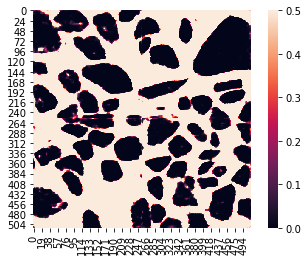

In [17]:
#Check to corect the boundary of grain

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#input data
model = load_model('model.hdf5')
image = cv2.imread('original/Cut_simg0.tif')

# size of Conv2D nodes
window_x = 256
window_y = 256
    
# size of the image to process
image_x = image.shape[0]
image_y = image.shape[1]
    
# image to store result
result_image = np.zeros([image_x, image_y])
result_lim = np.zeros([image_x, image_y])
    
# normalization of the input image
norm_image = np.zeros((1, image.shape[0], image.shape[1], 3),np.float32)
b=image[:,:,0]
g=image[:,:,1]
r=image[:,:,2]
norm_image[0, :,:,0] = cv2.equalizeHist(b)
norm_image[0, :,:,1] = cv2.equalizeHist(g)
norm_image[0, :,:,2] = cv2.equalizeHist(r)
norm = imagenet_utils.preprocess_input(norm_image)
    
# number of repetation applying the model
x_apply_num = int(image_x / window_x) 
y_apply_num = int(image_y / window_y)
    
for i in range(x_apply_num):
    x_begin = i * window_x
    x_end = (i + 1) * window_x
    for j in range(y_apply_num):
        y_begin = j * window_y
        y_end = (j + 1) * window_y
        predicted = model.predict(norm[:, x_begin:x_end, y_begin:y_end, :])
        predicted_image_bw = np.zeros([window_x, window_y])
        one = np.where(predicted[0].reshape(window_x, window_y, 2)[:,:,1] > 0.5)
        predicted_image_bw[one] = 255
        lim_prob = predicted[0].reshape(window_x, window_y,2)[:, :, 1] #lim prob
        result_image[x_begin:x_end, y_begin:y_end] = predicted_image_bw[:, :]
        result_lim[x_begin:x_end, y_begin:y_end] = lim_prob[:, :]
    predicted = model.predict(norm[:, x_begin:x_end, (image_y - window_y):, :]) #lim result
    predicted_image_bw = np.zeros([window_x, window_y])
    one = np.where(predicted[0].reshape(window_x, window_y, 2)[:,:,1] > 0.5)
    predicted_image_bw[one] = 255
    lim_prob = predicted[0].reshape(window_x, window_y,2)[:, :, 1] #lim prob
    result_image[x_begin:x_end, (image_y - window_y):] = predicted_image_bw[:, :]
    result_lim[x_begin:x_end, (image_y - window_y):] = lim_prob[:, :] #lim result
    
for j in range(y_apply_num):
    y_begin = j * window_y
    y_end = (j + 1) * window_y
    predicted = model.predict(norm[:, (image_x - window_x):, y_begin:y_end, :])
    predicted_image_bw = np.zeros([window_x, window_y])
    one = np.where(predicted[0].reshape(window_x, window_y, 2)[:,:,1] > 0.5)
    predicted_image_bw[one] = 255
    lim_prob = predicted[0].reshape(window_x, window_y,2)[:, :, 1] #lim prob
    result_image[(image_x - window_x):, y_begin:y_end] = predicted_image_bw[:, :]
    result_lim[(image_x - window_x):, y_begin:y_end] = lim_prob[:, :] #lim result
    
result0 = result_image
#cv2.imwrite('model_fit205.png', result0)
plt.imshow(result0)

#check the heatmap of the probability of lim
#print(lim_prob)
#sns.heatmap(result_lim, vmin=0.0, vmax=0.000003, square=True)
lim_image = sns.heatmap(result_lim, vmin=0.0, vmax=0.5, square=True)
plt.savefig('lim_image601_05.png')

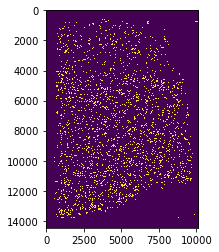

In [12]:
model = load_model('model_03.hdf5')
image = cv2.imread('Scan_image/KA01-2.tif')
result0 = apply_model(model, image)
cv2.imwrite('result_ka01-2.png', result0)
plt.imshow(result0)

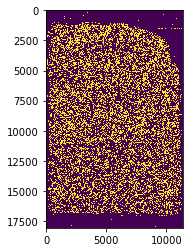

In [10]:
model = load_model('model_03.hdf5')
image = cv2.imread('Scan_image/AN10.tif')
result0 = apply_model(model, image)
cv2.imwrite('result_an10.png', result0)
plt.imshow(result0)

In [11]:
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

model = load_model('./model_03.hdf5')
x_test = np.load('x_test_03.npy')
testimage = np.array([x_test[0],])
predicted_image = model.predict(testimage)
# first_image = cv2.imread('scan500/Cut_simg0.tif')

True

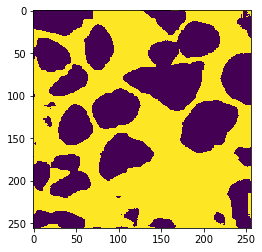

In [32]:
import cv2

a = 4

x_test_01 = np.load('x_test_03.npy')
predicted_image = model.predict(x_test_01)
predicted_image_bw = np.zeros([256,256])
one = np.where(predicted_image[a].reshape(256,256,2)[:,:,1] > 0.5)
predicted_image_bw[one] = 255
plt.imshow(predicted_image_bw)
cv2.imwrite('model_03_07.png', predicted_image_bw)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

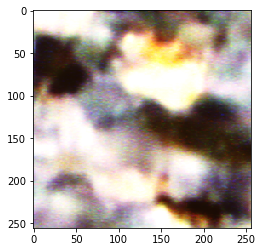

In [33]:
plt.imshow((x_test[a]+128).astype('int64'))
cv2.imwrite('target_03_07.png', (x_test[a]+128).astype('int64'))

True

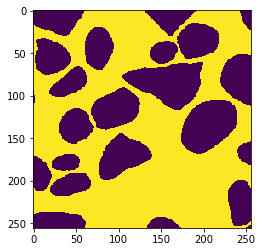

In [34]:
y_test = np.load('y_test_03.npy')
plt.imshow((y_test[a].reshape(256,256,2)[:,:,1]*255).astype('int64'))
cv2.imwrite('traced_03_07.png', (y_test[a].reshape(256,256,2)[:,:,1]*255).astype('int64'))

In [26]:
import cv2
import os
from  keras.applications import imagenet_utils
import numpy as np

def preprocess_y(y):
        
    data_shape = 128 * 128
        
    return np.reshape(y, (y.shape[0], data_shape, 2))
    
def one_hot_it(labels):
    y = np.zeros([512,512, 2])
    one = np.where(labels == 1)
    zero = np.where(labels != 1)
    y[one[0], one[1], 1] = 1
    y[zero[0], zero[1], 0] = 1
    return y
    
def normalize(rgb):
     
    norm = np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0] = cv2.equalizeHist(b)
    norm[:,:,1] = cv2.equalizeHist(g)
    norm[:,:,2] = cv2.equalizeHist(r)

    return norm

        
original_prefix = 'Cut_simg'
trace_prefix = 'Cut_pimg'
original_images_folder = 'original'
traced_images_folder = 'trace'
num_images = 10

original_list = []
for i in range(num_images):
    original_list.append(original_prefix + '{}.tif'.format(i))

trace_list = []
for i in range(num_images):
    trace_list.append(trace_prefix + '{}.tif'.format(i))

x = []
for filename in original_list:
    img = cv2.imread(os.path.join(original_images_folder,filename))
    if img is not None:
        x.append(img)
y = []
for filename in trace_list:
    img = cv2.imread(os.path.join(traced_images_folder,filename))
    if img is not None:
        y.append(img)
original_image_shape = y[0].shape



# split images
x_division = int(x[0].shape[0] / 128)
y_division = int(x[0].shape[1] / 128)

x_set_list = []
y_set_list = []

#         for i in range(len(y)):
for i in range(len(x)):
    x_norm = normalize(x[i])
    y_gray = (np.sum(y[i][:, :, :], axis=2) / (255 * 3)).astype('int64')
    y_label = one_hot_it(y_gray)
    for j in range(x_division):
        for k in range(y_division):
            x_set_list.append(x_norm[
              j * 128:(j + 1) * 128,
              k * 128:(k + 1) * 128, :])
            y_label_sub = y_label[j * 128:(j + 1) * 128,
              k * 128:(k + 1) * 128, :]
            y_set_list.append(y_label_sub)

x_set = np.array(x_set_list)
y_set = np.array(y_set_list)
test = 10
number_of_imageset = len(x_set)

x_train = imagenet_utils.preprocess_input(x_set[0:number_of_imageset - test,:,:,:])
x_test = imagenet_utils.preprocess_input(x_set[number_of_imageset - test:,:,:,:])
y_train = preprocess_y(y_set[0:number_of_imageset - test, :, :, :])
y_test = preprocess_y(y_set[number_of_imageset - test:,:,:,:])
        

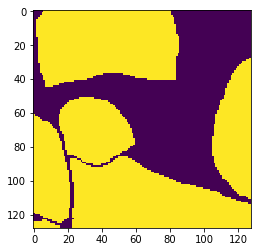

In [40]:
import matplotlib.pyplot as plt
plt.imshow(y_train[20].reshape(128,128,2)[:,:,0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


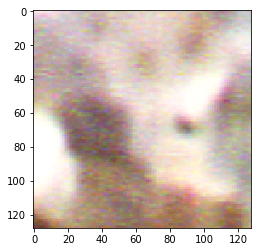

In [29]:
plt.imshow((x_train[20]+128).astype('int64'))

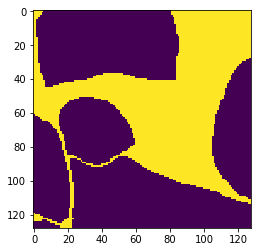

In [33]:
plt.imshow((y_train[20].reshape(128,128,2)[:,:,1]*255).astype('int64'))

In [37]:
# first_traced_image = cv2.imread('trace500/Cut_pimg0.tif')
# print(y_test[0].shape)
plt.imshow((y_test[20].reshape(128,128,2)[:,:,1]*255).astype('int64'))

IndexError: index 20 is out of bounds for axis 0 with size 10